Epoch 1, Train Loss: 4.735661519201178, Val Loss: 4.683900690078735, Train Acc: 0.75, Val Acc: 0.6666666666666666
Epoch 2, Train Loss: 4.599995776226646, Val Loss: 4.62273588180542, Train Acc: 1.4166666666666667, Val Acc: 0.6666666666666666
Epoch 3, Train Loss: 4.559891838776438, Val Loss: 4.702357387542724, Train Acc: 1.75, Val Acc: 2.0
Epoch 4, Train Loss: 4.4714336520747135, Val Loss: 4.706691265106201, Train Acc: 3.9166666666666665, Val Acc: 2.0
Epoch 5, Train Loss: 4.382185258363423, Val Loss: 4.782666826248169, Train Acc: 4.666666666666667, Val Acc: 1.0
Epoch 6, Train Loss: 4.241917905054595, Val Loss: 4.790256214141846, Train Acc: 7.0, Val Acc: 1.0
Epoch 7, Train Loss: 4.111504473184285, Val Loss: 4.871135473251343, Train Acc: 8.666666666666666, Val Acc: 1.6666666666666667
Epoch 8, Train Loss: 3.968579204458939, Val Loss: 4.829086256027222, Train Acc: 12.25, Val Acc: 2.3333333333333335
Epoch 9, Train Loss: 3.839984241284822, Val Loss: 4.861055564880371, Train Acc: 13.41666666666

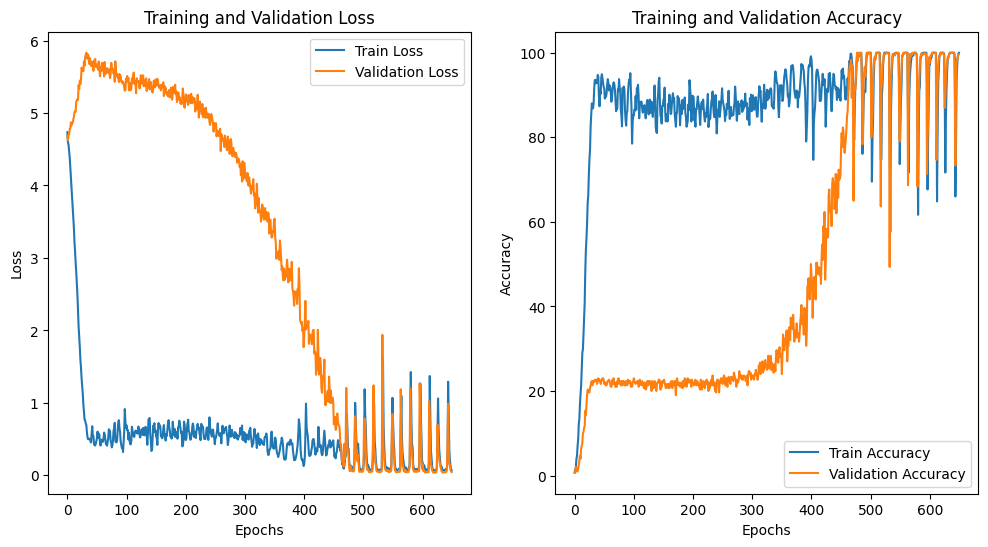

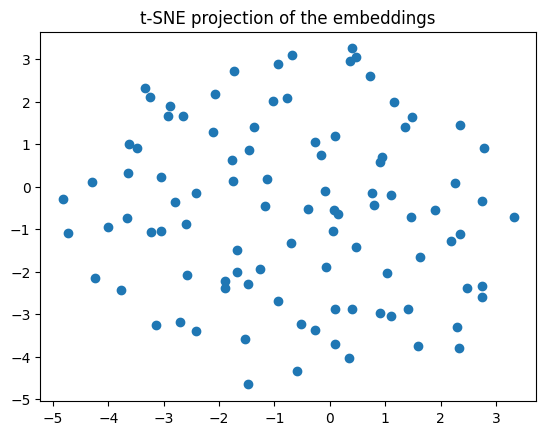

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Define the transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_dim):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, model_dim)
        self.transformer = nn.Transformer(d_model=model_dim, nhead=num_heads, num_encoder_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(model_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x, x)
        x = self.fc(x.mean(dim=1))
        return x

# Generate dataset
def generate_data(op, p, size):
    data = []
    for _ in range(size):
        a, b = np.random.randint(0, p, size=2)
        if op == "add":
            c = (a + b) % p
        elif op == "sub":
            c = (a - b) % p
        elif op == "mul":
            c = (a * b) % p
        elif op == "div":
            if b == 0:
                b = 1
            c = (a // b) % p
        data.append((a, b, c))
    return data

# Prepare dataset for training
def prepare_dataset(data, p):
    X = []
    y = []
    for a, b, c in data:
        X.append([a, b])
        y.append(c)
    X = torch.tensor(X, dtype=torch.long).cuda()
    y = torch.tensor(y, dtype=torch.long).cuda()
    return X, y

# Train the model
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs, patience):
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        for X, y in train_loader:
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += y.size(0)
            correct_train += (predicted == y).sum().item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        train_accuracies.append(100 * correct_train / total_train)

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for X, y in val_loader:
                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += y.size(0)
                correct_val += (predicted == y).sum().item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(100 * correct_val / total_val)

        print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}, Train Acc: {train_accuracies[-1]}, Val Acc: {val_accuracies[-1]}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter > patience:
                print("Early stopping")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies


def main():
    p = 97  # Prime number for modulo operations
    op = "add"  # Operation: "add", "sub", "mul", "div"
    dataset_size = 1500  # Size of the dataset
    input_dim = p
    model_dim = 128
    num_heads = 4
    num_layers = 2
    output_dim = p
    batch_size = 32
    epochs = 650  # Extended training duration
    learning_rate = 1e-3  # Learning rate based on paper details
    weight_decay = 1  # As specified in the paper
    patience = 700  # Early stopping patience

    data = generate_data(op, p, dataset_size)
    X, y = prepare_dataset(data, p)

    train_size = int(0.8 * dataset_size)
    train_data = torch.utils.data.TensorDataset(X[:train_size], y[:train_size])
    val_data = torch.utils.data.TensorDataset(X[train_size:], y[train_size:])
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

    model = TransformerModel(input_dim, model_dim, num_heads, num_layers, output_dim).cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, criterion, optimizer, train_loader, val_loader, epochs, patience)

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.show()

    # Visualize embeddings
    embeddings = model.embedding.weight.detach().cpu().numpy()
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(embeddings)
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
    plt.title('t-SNE projection of the embeddings')
    plt.show()

if __name__ == "__main__":
    main()
